### A new try at making ice sublimation or deposition fronts in a primordial porous pebble

Here I am using a diffusive approximation and the vapor pressure equal to partial pressure line to 
estimate the amoung of ice depositive by a water vapour rich front. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import pickle  # for storing python classes in binary files 

plt.rc('text', usetex=True)

In [2]:
# constants, treated as global variables
#m_p = 1.67262192595E-27   # kg mass of proton in m
G = 6.67408E-11 #  × m3 kg-1 s-2
k_B = 1.3806503E-23 # m2 kg s-2 K-1 is also J K-1
AU = 1.5e11 # in m
R_gas = 8.314  # idea gas constant in J K-1 mol-1
N_A = 6.02214076E23 # Avogadro's number R_gas = k_B*N_A  is also molecules per mole-1 
sigma_SB = 5.670374419E-8 # W m−2 K−4.  # Stefan Boltzmann constant 
AMU = 1.66053906660E-27   # atomic mass unit in m 
m_u = AMU
hour = 60*60.0  # in s
Msol = 2e30 # kg
Rsol = 7e8 # m

# some typical values 
#rho_n = 1.0E-5 # kg/m^3 density of disk at 1AU , could up by a few? in shock
#rho_A = 100.0 # kg/m3 # asteroid density (rather low?)
#K_T = 1e-1 # thermal conductivity asteroid stuff W m-1 K-1, like balsa wood 
#C_P = 1.0E3 # J kg−1 K−1 #specific heat of most stuff to order of mag
# number density in protosolar nebula is of order 10^21 m-3
# pressure in protosolar nebula is a few Pa

fileroot = 'ice_front_v01_'

Vapor pressure of olivine Costa+17 (note 1 bar = $10^5$ Pa)
$$P_v(T)  = {\rm Pa\ } 10^5 \times 10^{6.9908 -22519.0/T}$$ 

Vapor pressure of water  August equation https://en.wikipedia.org/wiki/Vapour_pressure_of_water
\begin{align}
P_v(T) & = e^{20.386-5132.0/T} {\rm mmHg} \times \frac{133.3224 \ {\rm Pa}}{\rm mmHg}  \\
& = {\rm Pa\ } 10^{10.97843}  10^{- \frac{2228.8}{T}} 
 = {\rm Pa\ } e^{25.279 - 5132.0/T}
\end{align}

For CO ice  
$$P_v(T) = 10^5 e^{10.25 - 748.2/T} \rm {Pa} = e^{21.7629  - 748.2/T} \ {\rm Pa}$$ 
from Fray+09 exp version $a_{CO} = 1.025 \times 10$ (bar),  $ b_{CO} = 7.482 \times 10^2$. 


In [3]:
# given Pv(T) form  Pv(T) = 10^(a - b/T) convert to  e^(A - B/T)
def convcofs_toexp(a_k,b_k,fromunits,cstring):
    A_k = np.log(np.power(10,a_k)) 
    B_k = np.log(10)*b_k
    if (fromunits == 'mmHg'):
        A_k += np.log(133.3224)
    if (fromunits == 'bar'):
        A_k += np.log(np.power(10,5))
    print(cstring,"Ak={:.3f} Pa Bk={:.3e}".format(A_k, B_k))

convcofs_toexp(6.9908,22519.0,'bar','olivine') # for olivine

print('CO ice Ak ={:.3f} Pa  Bk = {:.3f}'.format(np.log(10)*5 +10.25 ,748.2 )) # fray 09

print('CO2 ice Ak ={:.3f} Pa  Bk = {:.3f}'.format(np.log(10)*5 +18.61, 4.154E3 )) # fray 09

print('water ice Ak = {:.3f} Pa'.format(np.log(133.3224) + 20.386)) 

# here at the coefficients exp form Pa
A_k = [0.0, 25.279, 21.763, 30.123, 27.61]
B_k = [0.0, 5132.0, 748.2, 4154. ,  5.185e+04]


# for CO2 ice from Fray 09
#1.861E1 4.154E3 

olivine Ak=27.610 Pa Bk=5.185e+04
CO ice Ak =21.763 Pa  Bk = 748.200
CO2 ice Ak =30.123 Pa  Bk = 4154.000
water ice Ak = 25.279 Pa


In [4]:

# arrays of information about constituents
# requires globals:
#  AMU atomic mass unit in kg

class info():
    def __init__(self):
        self.klabels = ['hydrogen', 'water', 'carbon monoxide', 'carbon dioxide','rocky']  # constituents
        self.n_k = len(self.klabels)  # number of constituents in gas or/and solid phases 
        self.Ag_karr = np.array([2.0,18.0,28.0,44.0, 35.0])  # molecular weights for materials when they are gas components A_gk (unit-less)
        self.beta_gkarr = np.array([1.7, 2.3, 2.3, 2.3, 2.3])  # specific heat correction factors (unit-less) beta_gk
        self.rho_skarr = np.array([1.0, 1.0e3, 900.0, 1640., 3.0e3])  # density of solid versions (kg m-3)
        self.Pv_fun0_karr = np.array([0.0, 25.279, 21.763, 30.123, 27.61]) # vapor pressure functions, A_k constant terms but for (Pa)
        self.Pv_fun1_karr = np.array([0.0, 5132.0, 748.2, 4154, 5.185e+04]) # exponent B terms (K) 
        self.etype = 'exp'  # vapor pressures Pv in form e^(A - B/T) giving result in Pa
        self.Hsub_karr = np.array([0.0, 2840.0E3, 2.16E5, 7.5e5, 2E7])  # latent heats for sublimation/condensation J/kg
        self.Hsub_mol_karr = self.Hsub_karr*(self.Ag_karr*AMU)  # latent heat per molecule in J/molecule
        # Hsub: for water-ice sublimation https://en.wikipedia.org/wiki/Latent_heat 
        # Hsub: for rock see above calculation which is based on a number from Costa+17?
        # For CO ice Leliwa+13

        # an effective specific heat per unit mass for solid materials 
        self.C_uni = 3E6  # units J m-3 K-1 universal value for the product of density and specific heat for solids  
        self.K_Tuni = 1.  # typical value for solid brick, concrete, glass, thermal conductivity in units of J/s m-1 K-1 
        # note that if you take K_Tuni/C_uni you get units of m^2/s as expected 

        #self.n_s_fracs = np.array([0.9,0.1,0.0,0.0]) 
        # these might be nebular partial pressures or number densities
        
        self.n_skarr = self.rho_skarr/(self.Ag_karr*AMU)  # compute number density in solid components 

# make this a variable we can pass around 
cinfo = info()

print(cinfo.n_skarr)  # number densities in solid components 
print(cinfo.Hsub_mol_karr) # J/mol latent heats
print(cinfo.Pv_fun0_karr) # A_k vals
print(cinfo.Pv_fun1_karr) # B_k vals

[3.01107038e+26 3.34563376e+28 1.93568810e+28 2.24461610e+28
 5.16183494e+28]
[0.00000000e+00 8.48867571e-20 1.00429403e-20 5.47977892e-20
 1.16237735e-18]
[ 0.    25.279 21.763 30.123 27.61 ]
[    0.   5132.    748.2  4154.  51850. ]


In [5]:
# values near 1AU
P_n = 10.0 # in Pa
T_n = 170
print('n nebular {:.3e}'.format(P_n/(k_B*T_n)))  # checking n0


n nebular 4.261e+21


In [7]:
# to compute vapor pressure in Pa for gas constituent k, k is an integer index 
# uses info arrays Pv_fun0_karr, Pv_fun1_karr and class structure cinfo (class info)
# T can be an array and is in Kelvin
def Pv(T,k,cinfo):
    Afun = cinfo.Pv_fun0_karr[k]
    Bfun = cinfo.Pv_fun1_karr[k]
    if (cinfo.etype == 'exp'):
        return np.exp(Afun - Bfun/T)
        #vapor pressures Pv in form e^(A - B/T) giving result in Pa, T in K
    elif (cinfo.etype == 'power10'):
        return np.power(10.0, Afun - Bfun/T)
        #vapor pressures Pv in form 10^(A - B/T) giving result in Pa, T in K
    else:
        print('Pv error')
        
# for gas component, specific heat per molecule, in J per molecule for gas constituent k 
# uses info array beta_gkarr
def c_gk(T, k, cinfo):
    beta = cinfo.beta_gkarr[k]
    return 2.5*k_B*T*beta  # not currently used

#def alpha_ice(T,k):
def alpha_ice(k):
    return 0.5

In [8]:
# requires globals:
#   Pv(T,k,cinfo) routine to compute vapor pressures
#   alpha_ice(T) for alpha fudge factor in Hertz-Knudsen absoprtion equation 
#   class info() defined above 
#   k_B Boltzmann constant , AMU
# assuming k=0 is H2
# there are no catches for solidification 
class heat_sim():
    def __init__(self,cinfo,dz,nz,porosity,rpore,T_init,Ttop,Ptop,n_s_fracs,dt,sim_label='',onlist = [],fv_ice_init=[]):
        self.nk = cinfo.n_k  # number of gas species  
        self.nz = nz  # grid size
        self.dz = dz  # grid length
        self.zarr = np.arange(nz)*self.dz  # depth values 
        self.porosity = porosity  # porosity 
        self.rpore = rpore  # pore size 
        self.sim_label = sim_label
        
        if (len(onlist) ==0):  # which species we are integrating 
            self.onlist = np.ones(self.nk,dtype=bool)  # all of them True
            for k in range(2,self.nk):  # without specifying we only integrate 0,1 with 1=water 
                self.onlist[k] = False 
        else:
            self.onlist = onlist  # should be a boolean list of species integrated
            
        if (len(fv_ice_init) == 0): # initial ice volume fractions
            self.fv_ice_init = np.zeros(self.nk)
        else:
            self.fv_ice_init = fv_ice_init # assumed to be an array of fractions 
        
        self.T_init = T_init  # equilibrium temperature prior to heating event 
        #self.fv_ice_init = fv_ice_init 
        self.Ttop = Ttop # surface temperature 
        self.Ptop = Ptop  # surface pressure 
        self.n_s_fracs = n_s_fracs # array of initial surface number gas density fractions, should sum to 1 
        self.cinfo = cinfo  # information class info() contains info about solids and gasses 
        self.time = 0.0
        self.k_B = k_B   # make a local variable in case helps with speed 
        self.AMU = AMU
        
        self.dt = dt # timestep 
        self.kappa = (1-self.porosity)*self.cinfo.K_Tuni/self.cinfo.C_uni  # diffusive T transport in solid only 

        # allocate arrays 
        self.Tarr  = np.zeros(nz) # array of temperatures 
        self.Pvarr = np.zeros((self.nk,self.nz)) # arrays of vapor pressures 
        self.narr  = np.zeros((self.nk,self.nz))  # arrays of number densities in gas constituents
        self.Parr  = np.zeros((self.nk,self.nz))  # arrays of partial pressures in gas 
        self.niarr = np.zeros((self.nk,self.nz))  # number of molecules per unit volume in solid phases 
        
        self.vtarr = np.zeros((self.nk,self.nz)) # arrays of thermal velocities for each gas consituent 
        
        self.dh = np.zeros(self.nz)  # heat generated per condensed or sublimated molecule in a timestep
        self.fv_ice = np.zeros((self.nk,self.nz)) # condensed ice volume fractions 

        # arrays for storage 
        self.nshow = 1
        self.nk_store   = np.zeros((self.nshow,self.nz))
        self.T_store    = np.zeros((self.nshow,self.nz))
        self.fice_store = np.zeros((self.nshow,self.nz))
        self.time_store = np.zeros(self.nshow)
        self.nint = 1 

        self.init_arrays() # initialize arrays 
        
    # initialize arrays or reset
    def init_arrays(self):
        self.time = 0.0
        self.Tarr[1:] = self.T_init # initialize internal temperature 
        self.Tarr[0] = self.Ttop  # surface value of temperature 
        self.load_Pv()  # load the Pvarr partial pressure arrays based on the initial temperature 
        self.load_vt()  # load thermal speed arrays 
        self.dh     *= 0.0
        self.fv_ice *= 0.0 
        self.niarr  *= 0.0
        for k in range(1,self.nk):   # set up initial ice fractions 
            if (self.fv_ice_init[k] >0):
                self.fv_ice[k,:] = self.fv_ice_init[k]  # volume fraction of ice 
                self.niarr[k,:]  = self.fv_ice_init[k]*self.cinfo.n_skarr[k] # number density in ice 

        for k in range(self.nk):  # set surface partial pressures 
            self.Parr[k,0] = self.Ptop*self.n_s_fracs[k] 
        # we set all constituents so their partial pressures are equal to their vapor pressure values except at the surface 
        # we adjust hydrogen so that gas pressure is equal everywhere to the surface one
        Ptotal = 0.0
        for k in range(1,self.nk):
            Pvmax= Pv(self.T_init,k,self.cinfo) # is a number, for initial cold interior temperature T_init 
            Pset = min(self.Ptop*self.n_s_fracs[k], Pvmax) # choose minimum of initial partial at surface or Pv
            self.Parr[k,1:] = Pset  # set everywhere but surface 
            Ptotal += Pset
        self.Parr[0,1:] = self.Ptop - Ptotal # initialize partial pressure array of hydrogen 
        for k in range(self.nk):  # initialize number density arrays 
            self.narr[k,:] = self.Parr[k,:]/(self.k_B * self.Tarr)

        if (self.Ttop > 400):  # zero out ices in top two grid positions 
            for k in range(1,self.nk):
                self.niarr[k,0:1] = 0 
        
    # solid heat transport only using universal values for diffusion coefficient kappa 
    # top-surface value in array is not changed 
    # Forward Time Centered Space Scheme
    def update_Tarr(self):  
        new_Tarr = np.zeros(self.nz)
        lap = (np.roll(self.Tarr,1) + np.roll(self.Tarr,-1) - 2*self.Tarr)*self.kappa*self.dt/self.dz**2  #Laplacian 
        lap[0] = 0  # kill the boundaries in the laplacian 
        lap[-1]= 0
        new_Tarr = self.Tarr + lap   # top value for temperature is not affected 
        new_Tarr[-1] = new_Tarr[-2]  # float the bottom boundary 
        #new_Tarr[0] = self.Ttop  # set top to be fixed, could be varied for a time dependent boundary condition 
        self.Tarr = new_Tarr # update temperature array 
        self.time += self.dt # update integration time 

    # compute vapor pressures of gas constituents in arrays 
    def load_Pv(self):  
        for k in range(1,self.nk):  # don't do first array index, as we assume is hydrogen
            if (self.onlist[k] == True):  # only update active arrays 
                self.Pvarr[k,:] = Pv(self.Tarr,k,self.cinfo)  # calls external routine Pv, in Pa

    # compute thermal velocities of each molecule gas constituent in arrays, 
    def load_vt(self): 
        for k in range(self.nk):
            if (self.onlist[k] == True):  # only update active arrays 
                self.vtarr[k,:] = np.sqrt(8* self.k_B *self.Tarr/(np.pi*self.cinfo.Ag_karr[k] *self.AMU))
                # Ag_karr[k] *AMU is the mass of molecule species

    # allow diffusion in the water vapor based on the gradient in its number density 
    # a fundamental problem is that the thermal timestep is much bigger than the diffusive one, 
    # so diffusion is done here with an adjustible timestep to make sure it it stable 
    # condensation/sublimation and heat are not taken into account in this routine 
    def diffuse(self):  # allow different gases to diffuse if there are variations in their number densities
        self.load_vt()  # compute thermal velocities - only varies with T
        self.load_Pv()  # update vapor pressure arrays - only varies with T 
        kTarr = self.k_B*self.Tarr   #k_B T array
        self.dh *= 0  # zero out the heat array 

        # loop for diffusion, mass and energy transport of each species 
        for k in range(1, self.nk):  # ignoring H2 which is k=0
            if (self.onlist[k]==True):   #k=1 # water  
                #compute quantities that don't depend on number densities, only on temperature 
                Pvk = np.squeeze(self.Pvarr[k,:])  # vapor pressure 
                nvk = Pvk/kTarr        # number density of vapor pressure 
                vtk = np.squeeze(self.vtarr[k,:])  # thermal velocity 
                dif_cof = vtk * self.rpore/3  # compute Knudsen diffusion coefficient , is a vector 
                max_dif_cof = max(dif_cof)  # maximum value (in hottest region)
                dfac = 3  # must be >2 for stability of scheme
                dif_dt = self.dz**2/max_dif_cof/dfac  # choose a stable value for timestep 
                ndt = max(int(self.dt/dif_dt),1)  # divide the timestep into intervals 
                dif_dt = self.dt/ndt  # choose our timestep for diffusion 
                afac = dif_cof*dif_dt/self.dz**2  # is a vector for use in time loop 

                #Pk  = np.squeeze(self.Parr[k,:])   # partial pressure
                nk  = np.copy(np.squeeze(self.narr[k,:]))   # number density of gas pressure 
                nik = np.copy(np.squeeze(self.niarr[k,:]))  # number density of solid phase 

                #alpha_ice_s = alpha_ice(self.Tarr,k)  # a vector 
                alpha_ice_s = alpha_ice(k)  # a number right now 

                # diffuse and condense/sublimation together, multiple small steps , the mini loop!
                for j in range(ndt):  
                    new_nk  = np.copy(nk)  # new gas phase number density 
                    new_nik = np.copy(nik)  # new ice number density 

                    # diffusion of number density of vapor
                    lap = (np.roll(new_nk,1) + np.roll(new_nk,-1) - 2*new_nk)*afac  #Laplacian 
                    lap[0] = 0  # kill the boundaries in the laplacian, top is Dirichlet and is not changed
                    lap[-1]= 0
                    new_nk+=lap  # diffuse! update array 
                    new_nk[-1] = new_nk[-2]  # float bottom boundary 

                    dnnv = (new_nk - nvk) #  is positive where we want to condense because Partial pressure>vapor pressure 
                    tcond = (dnnv >=0) # where deposition/condensation takes place 
                    tsub = (dnnv <0)  # where sublimation can happen 

                    # Knudsen absorption formula to set evaporation rate 
                    #https://en.wikipedia.org/wiki/Hertz%E2%80%93Knudsen_equation
                    #https://www.sciencedirect.com/science/article/abs/pii/S0019103514000566
                    # take dn and multiply by v_t, this gives a number per unit time, area, we want number per unit time, volume
                    # so we divide by rpore 
                    # the area of a pore is rpore^2, but there are (dz/rpore)^3 pores about in the volume dz^3 
                    # so the number of pores times their area is dz^3/rpore 
                    # so the absorption rate should be dnn * vt/rpore (at most) 
                    # fudge factor here is the alpha that Kossacki measured and talks about in his comet studies 
                    dn = alpha_ice_s*dnnv*vtk/(4*self.rpore) * dif_dt # total maximum change in number density due to condensation or evaporation 
                    # check units mol/vol * m/s /m *s = mol/vol

                    # deposition/condensation to at most the vapor pressure value if partial pressure exceeds vapor pressure 
                    docond=1
                    if (docond==1):
                        dcond1 = np.logical_and ( (dnnv - dn >= 0 ), tcond)   # you can depose/condense all of dn
                        dcond2 = np.logical_and ( (dnnv - dn <0 ), tcond)   # you can depose/condense down to vapor pressure 
                        new_nk[dcond1]  -= dn[dcond1]  # remove condensed gas 
                        new_nik[dcond1] += dn[dcond1]  # add it to the ice 
                        self.dh[dcond1] += dn[dcond1]*self.cinfo.Hsub_mol_karr[k] # how much heat we gain from deposition/condensation 
                        # Hsub_mol_karr is in units of J/molecule so dh is units of J/volume
                        new_nk[dcond2]   = nvk[dcond2]   # gas is set to vapor pressure value 
                        new_nik[dcond2] += dnnv[dcond2]  # whatever there was past vapor pressure add it to the ice 
                        self.dh[dcond2] += dnnv[dcond2]*self.cinfo.Hsub_mol_karr[k]  # record heat gained from deposition/condensation 
                        # dh has units of J/volume

                    # sublimate ice if below vapor pressure and if there is ice 
                    # stores heat in self.dh !!!!
                    dosub=1
                    if (dosub==1): # sublimation 
                        dsub1 = np.logical_and( (nik - np.fabs(dn) >= 0), tsub) # you can sublimate, there is ice left over 
                        dsub2 = np.logical_and( (nik - np.fabs(dn) <0), tsub) # you can sublimate all the ice present
                        new_nik[dsub1]-= np.abs(dn[dsub1]) # remove ice 
                        new_nk[dsub1] += np.abs(dn[dsub1])  # add sublimated ice to gas number density 
                        self.dh[dsub1] -= np.abs(dn[dsub1])*self.cinfo.Hsub_mol_karr[k] # how much heat we loose from sublimation 
                        new_nik[dsub2] = 0   # remove all ice 
                        new_nk[dsub2] += np.abs(nik[dsub2])  # add sublimated ice to gas number density 
                        self.dh[dsub2] -= np.abs(nik[dsub2])*self.cinfo.Hsub_mol_karr[k] # how much heat we loose from sublimation 
                        # dh has units of J/volume

                    # updates within loop 
                    nk = new_nk
                    nik = new_nik
                    # end loop of mini timesteps

                # update arrays
                # surface value of narr (number density of vapor) is not affected, neither is that of Parr (partial pressure)
                self.narr[k,1:]  = nk[1:] # update number density of  vapor 
                self.Parr[k,1:]  = nk[1:]*kTarr[1:]  # update partial pressure 
                self.niarr[k,:]  = nik  # update number density of solid phase 
                self.fv_ice[k,:] = self.niarr[k,:]/self.cinfo.n_skarr[k]  # volume fraction of ice update 
                # cinfo.n_skarr[k] is the number density of the solid form 
        
        addheat = 1 
        # take heat of sublimation/condensation and adjust temperature of solid 
        if (addheat==1):
            dT = self.porosity*self.dh/self.cinfo.C_uni  # note using C_uni!!!! is correct ! 
            #  Add the heat to the solid 
            Tnew  = self.Tarr + dT  # C_uni has units J m-3 K-1
            jj = (Tnew > self.T_init) # no refrigeration allowed (helps code stability?)
            self.Tarr[jj] = Tnew[jj]    # update temperature array  # we had an error here!!!!!!
            # dh is supposed to have units of J/volume which means this should give a change in T
            # ignoring specific heat of the gas itself as it moves through the porous medium 

    # run nshow*nint time steps but only store nshow versions of some arrays 
    def run_save(self,nshow,nint):  
        self.nk_store   = np.zeros((nshow,self.nk,self.nz))  # allocate space 
        self.fice_store = np.zeros((nshow,self.nk,self.nz))
        self.T_store    = np.zeros((nshow,self.nz))
        self.time_store = np.zeros(nshow)
        for m in range(nshow):  # number of times to save 
            for j in range(nint):  # number of integration steps 
                self.update_Tarr()
                self.diffuse()

            for k in range(1,self.nk): # not storing hydrogen 
                if (self.onlist[k] == True):
                    self.nk_store[m,k,:] = self.narr[k,:]
                    self.fice_store[m,k,:] = self.fv_ice[k,:]
            
            self.T_store[m,:] = self.Tarr
            self.time_store[m] = self.time 
            
        print('time = {:.1f} s'.format(self.time))  
        self.nshow = nshow
        self.nint = nint 

    # similar to the previous routine but adding to the saved integration 
    def run_save_append(self,nshow_a):
        # expand the arrays 
        expand_zeros1 = np.zeros((nshow_a,self.nz))    
        self.T_store  = np.append(self.T_store,expand_zeros1,axis=0) 

        expand_zeros2 = np.zeros((nshow_a,self.nk,self.nz))    
        self.nk_store = np.append(self.nk_store,expand_zeros2,axis=0)
        self.fice_store = np.append(self.fice_store,expand_zeros2,axis=0)
        
        expand_zeros0 = np.zeros(nshow_a)
        self.time_store = np.append(self.time_store, expand_zeros0)
        for m in range(self.nshow,self.nshow+nshow_a):  # number of times to save 
            for j in range(self.nint):  # number of integration steps 
                self.update_Tarr()
                self.diffuse()

            for k in range(1,self.nk): # not storing hydrogen 
                if (self.onlist[k] == True):
                    self.nk_store[m,k,:] = self.narr[k,:]
                    self.fice_store[m,k,:] = self.fv_ice[k,:]
            
            self.T_store[m,:] = self.Tarr
            self.time_store[m] = self.time 

        self.nshow += nshow_a
        print('time = {:.1f} s'.format(self.time))  

    # change or update surface temperature and partial pressures 
    def set_top(self,Ttop,Ptop):
        self.Ptop = Ptop
        self.Ttop = Ttop
        #for k in range(self.nk):  # set surface partial pressures 
        #k=0
        #self.Parr[k,0] = self.Ptop*self.n_s_fracs[k] 
        self.Tarr[0] = self.Ttop
        Ptotal = 0.0
        for k in range(1,self.nk):
            Pvmax= Pv(self.Ttop,k,self.cinfo) # is  vapor pressure, for new temperature Ttop
            Pset = min(self.Ptop*self.n_s_fracs[k], Pvmax) # choose minimum of partial pressure at surface or Pvmax (vapor pressure)
            self.Parr[k,0] = Pset  # set surface value for constituent k
            Ptotal += Pset
        k=0
        self.Parr[k,0] = self.Ptop - Ptotal # initialize partial pressure of hydrogen at surface only
        for k in range(self.nk):  # initialize number density arrays at surface 
            self.narr[k,0] = self.Parr[k,0]/(self.k_B * self.Tarr[0])
        

In [21]:

# make a figure from stored simulation, if k=1 outputs water-vapor-ice only
# globals:  fileroot,  Pv()
# if k=1 : water,  k=2 : CO, k=3 : CO2
# if plot_pv=True show vapor pressure along with partial pressure
# if nshow_max = a number, then limit the number of plotted times 
def just_fig(sim,cstr='',k=1,plot_pv=False,nshow_max = None,dm=1):
    colorlist = ['black','brown','violet','blue','green','gold','orange','red']
    nc = len(colorlist)
    lw = 1

    fig,axarr = plt.subplots(4,1,figsize=(3.5,3),sharex=True,dpi=300)
        
    plt.subplots_adjust(hspace=0, wspace=0,left=0.23,bottom=0.15, top=0.98,right=0.96)
    
    nshow = sim.T_store.shape[0]
    if (nshow_max != None):
        nshow = min(int(nshow_max), nshow)  # limit to nshow_max 
    
    zarr = sim.zarr
    #k=1 for ice 

    #axarr[1].ticklabel_format(axis='y',useOffset=False,useMathText=True,scilimits=[-3,3],style='sci')
    axarr[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))
    axarr[1].tick_params(axis='y', which='major', labelsize=8)

    for m in range(1,nshow,dm):
        nk = np.squeeze(sim.nk_store[m,k,:])
        fice = np.squeeze(sim.fice_store[m,k,:])
        Tarr = np.squeeze(sim.T_store[m,:])
        Pvk = Pv(Tarr,k,sim.cinfo)  # vapor pressure 
        Pk = nk*sim.k_B*Tarr  # partial pressure
        #Pk = np.squeeze(sim.Parr[k,:])
        
        axarr[0].plot(zarr,np.log10(Pk),'-',color=colorlist[m%nc],lw=lw)
        if (plot_pv==True):
            axarr[0].plot(zarr,np.log10(Pvk),'-',color=colorlist[m%nc],lw=lw/2)
        
        axarr[1].plot(zarr,fice,'-',color=colorlist[m%nc],lw=lw)  # note no %
        jj = fice>0
        axarr[2].plot(zarr[jj],np.log10(fice[jj]),'-',color=colorlist[m%nc],lw=lw)  # not in % is a volume fraction
        axarr[3].plot(zarr,Tarr,'-',color=colorlist[m%nc],lw=lw)
        
    axarr[0].set_ylabel(r'log$_{10}p$(Pa)')
    axarr[1].set_ylabel(r'$f_\mathrm{ice}$', labelpad=-3)
    axarr[2].set_ylabel(r'log$_{10}f_\mathrm{ice}$')
    axarr[3].set_ylabel('T (K)')
    axarr[3].set_xlabel('depth z (m)')

    ofile = fileroot+sim.sim_label + cstr + '.png'
    print(ofile)    
    plt.savefig(ofile)
    plt.show()

In [26]:
iceA_redo= False   # set this to be false after you like iceA and have finished running it 

In [27]:

if (iceA_redo == True):

    dz = 0.002   # grid spacing in m 
    nz = 30  # grid length
    porosity = 0.5  # porosity, kept fixed 
    rpore = 1e-4    # pore size in m 
    T0 = 200  # initial interior temperature 
    Ttop = 800 #K  surface temperature
    Ptop = 100 # Pa  surface pressure 
    sim_label ='iceA'
    kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni  # diffusion coefficient for heat 
    dt = dz**2/kappa/4   # choose timestep for heating of solid medium 
    print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))

    n_s_fracs = np.array([0.9,0.1,0.0,0.0,0.0]) # volume number density fractions of nebular gas
    iceA = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,sim_label = sim_label)

    nshow=6; nint=10  # number of data sets to store, and number if integration steps between each one 
    iceA.run_save(nshow,nint)  # run the integration 

    # takes about 5 minutes!
    with open(fileroot + 'iceA.pkl', 'wb') as file:
        pickle.dump(iceA, file)

else:
    with open(fileroot + 'iceA.pkl', 'rb') as file:
        iceA = pickle.load(file)


ice_front_v01_iceAa.png


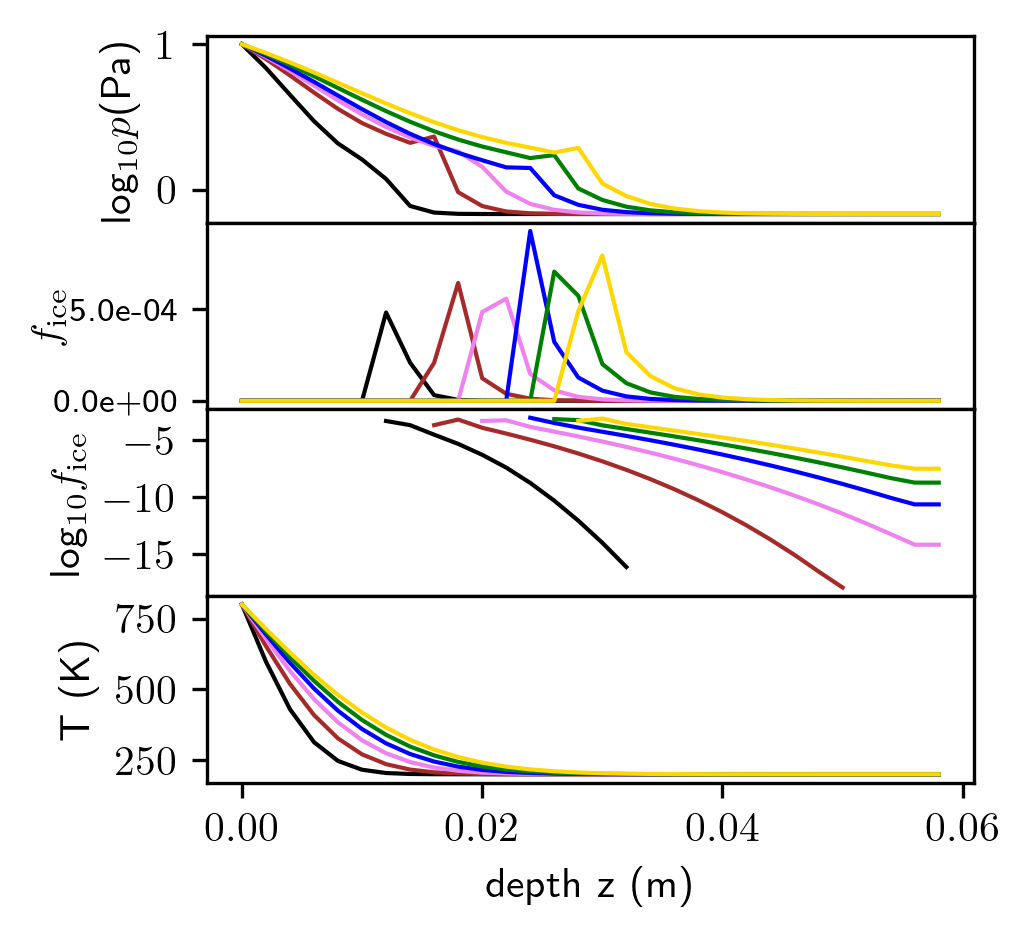

In [28]:
just_fig(iceA,'a',nshow_max=6)

In [29]:

if (iceA_redo == True):
    nshow_a=6; #nint=10
    iceA.set_top(200,100) # reset surface temperature to something lower 
    iceA.run_save_append(nshow_a) # run some more timesteps 

    with open(fileroot + 'iceA.pkl', 'wb') as file:
        pickle.dump(iceA, file)

else:
    with open(fileroot + 'iceA.pkl', 'rb') as file:
        iceA = pickle.load(file)

ice_front_v01_iceAb.png


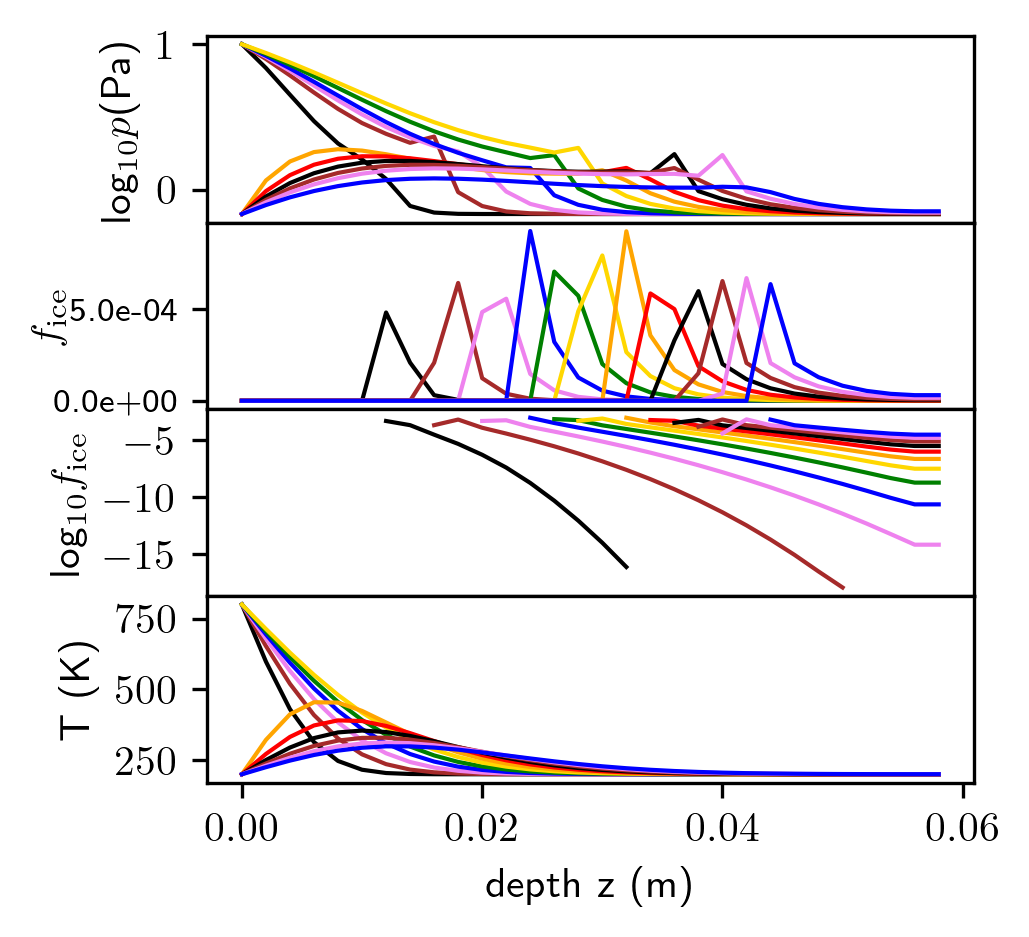

In [30]:
just_fig(iceA,'b')

In [ ]:
iceB_redo = False

In [33]:
#iceB_redo = True
if (iceB_redo == True):
    # test smaller grid, otherwise same parameters! will take twice as long
    dz = 0.001 # 0.1 cm = 1mm 
    nz = 60
    porosity = 0.5
    rpore = 1e-4   # 
    T0 = 200
    Ttop = 800 #K
    Ptop = 100 # Pa
    sim_label = 'iceB'
    kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
    dt = dz**2/kappa/4   # timestep for heating of solid medium 
    print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))

    n_s_fracs = np.array([0.9,0.1,0.0,0.0,0.0]) # volume number density fractions of nebular gas
    iceB = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,sim_label = sim_label)

    nshow=6; nint=10*4
    iceB.run_save(nshow,nint)
    # takes at least 10 minutes 

    with open(fileroot + 'iceB.pkl', 'wb') as file:
        pickle.dump(iceB, file)

else:
    with open(fileroot + 'iceB.pkl', 'rb') as file:
        iceB = pickle.load(file)


dt = 1.50 s, rpore = 1.0e-04 m, dz = 1.0e-03 m 
time = 360.0 s


In [31]:
just_fig(iceB,'a')

NameError: name 'iceB' is not defined

In [ ]:
iceC_redo = True

In [52]:
if (iceC_redo == True):
    # test initial icy body
    dz = 0.002 # 
    nz = 30
    porosity = 0.5
    rpore = 1e-4   # 
    T0 = 200
    Ttop = 800 #K
    Ptop = 100 # Pa
    sim_label = 'iceC'
    kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
    dt = dz**2/kappa/4   # timestep for heating of solid medium   
    print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))
    fv_ice_init = [0.0,0.05,0.0,0.0,0.0]

    n_s_fracs = np.array([0.9,0.1,0.0,0.0,0.0]) # volume number density fractions of nebular gas
    iceC = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,sim_label=sim_label,fv_ice_init = fv_ice_init)

    nshow=6; nint=10  # 
    iceC.run_save(nshow,nint)
    # takes 10 minutes or so
    
else:
    with open(fileroot + 'iceC.pkl', 'rb') as file:
        iceC = pickle.load(file)

dt = 6.00 s, rpore = 1.0e-04 m, dz = 2.0e-03 m 
time = 360.0 s


ice_front_v01_iceCa.png


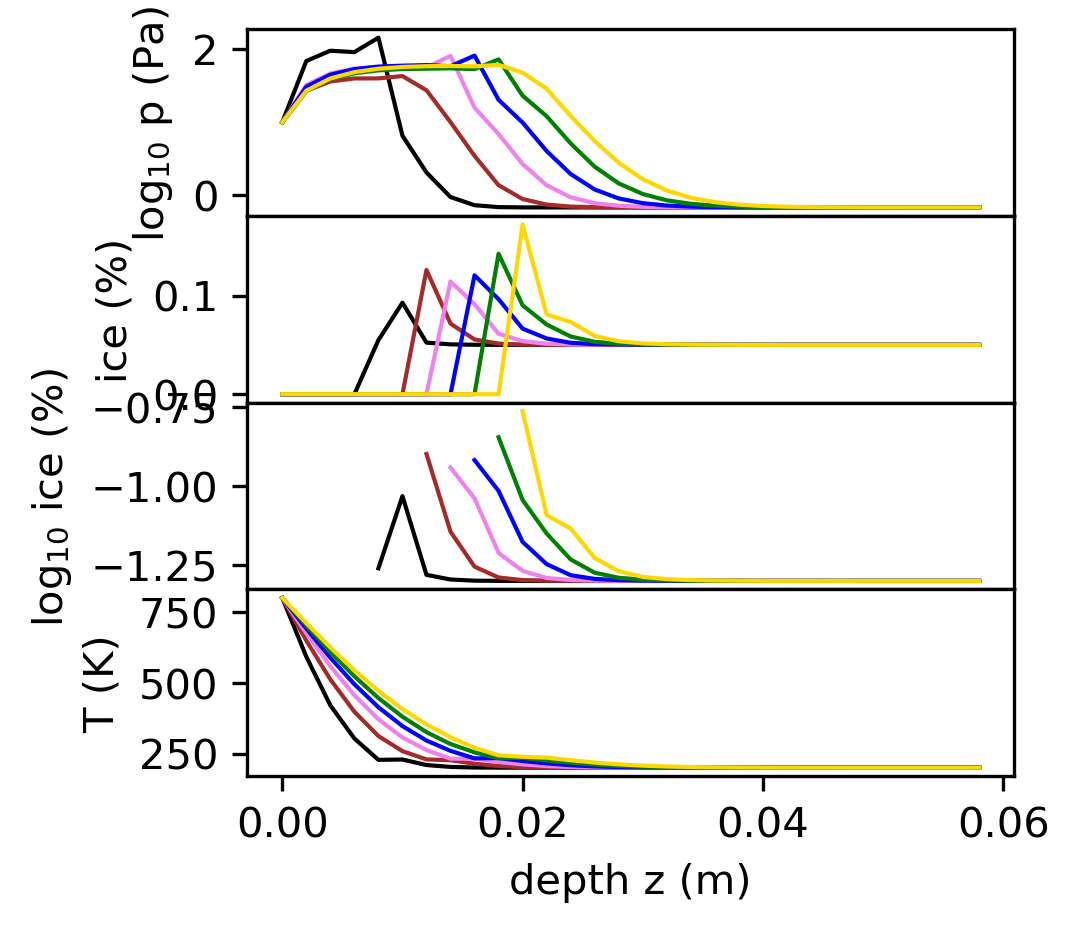

In [161]:
just_fig(iceC,'a',nshow_max = 6)

### existing ice moves in as it sublimates


In [162]:
if (iceC_redo == True):
    nshow_a=12; 
    iceC.set_top(200,100) # reset surface temperature to something lower 
    iceC.run_save_append(nshow_a) # run some more timesteps 

    with open(fileroot + 'iceC.pkl', 'wb') as file:
        pickle.dump(iceC, file)

else:
    with open(fileroot + 'iceC.pkl', 'rb') as file:
        iceC = pickle.load(file)

time = 720.0 s


ice_front_v01_iceCb.png


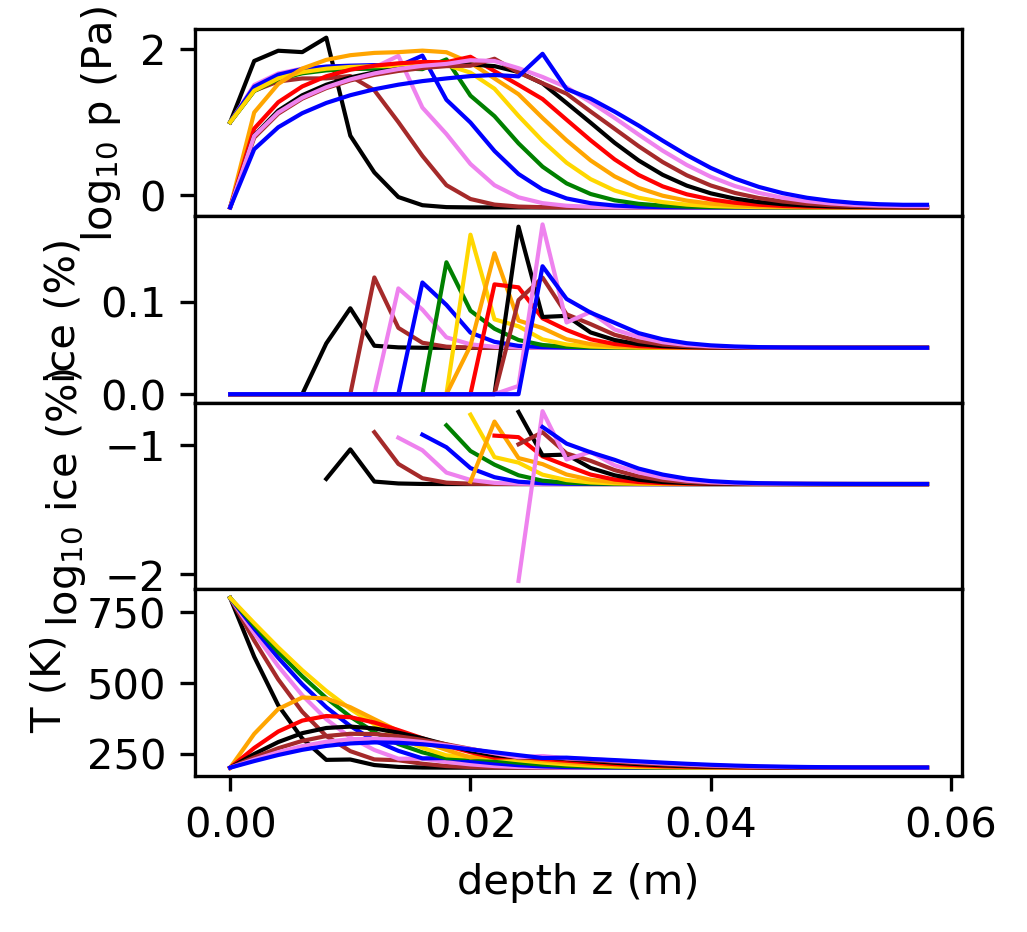

In [163]:
just_fig(iceC,'b')

## ice front continues to penetrate but slows down and get higher, maybe spreads out

In [ ]:
iceD_redo = True

In [167]:
if (iceD_redo == True):
    # change pore size, dry body 
    dz = 0.002 # 
    nz = 30
    porosity = 0.5
    rpore = 1e-5   # smaller pore size 
    T0 = 200
    Ttop = 800 #K
    Ptop = 100 # Pa
    sim_label = 'iceD'
    kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
    dt = dz**2/kappa/4   # timestep for heating of solid medium 
    print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))
    #fv_ice_init = [0.0,0.05,0.0,0.0]

    n_s_fracs = np.array([0.9,0.1,0.0,0.0,0.0]) # volume number density fractions of nebular gas
    iceD = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,sim_label=sim_label)

    nshow=6; nint=4
    iceD.run_save(nshow,nint)

    #with open(fileroot + 'iceD.pkl', 'wb') as file:
    #    pickle.dump(iceD, file)

else:
    with open(fileroot + 'iceD.pkl', 'rb') as file:
        iceD = pickle.load(file)


dt = 6.00 s, rpore = 1.0e-05 m, dz = 2.0e-03 m 
time = 144.0 s


ice_front_v01_iceDa.png


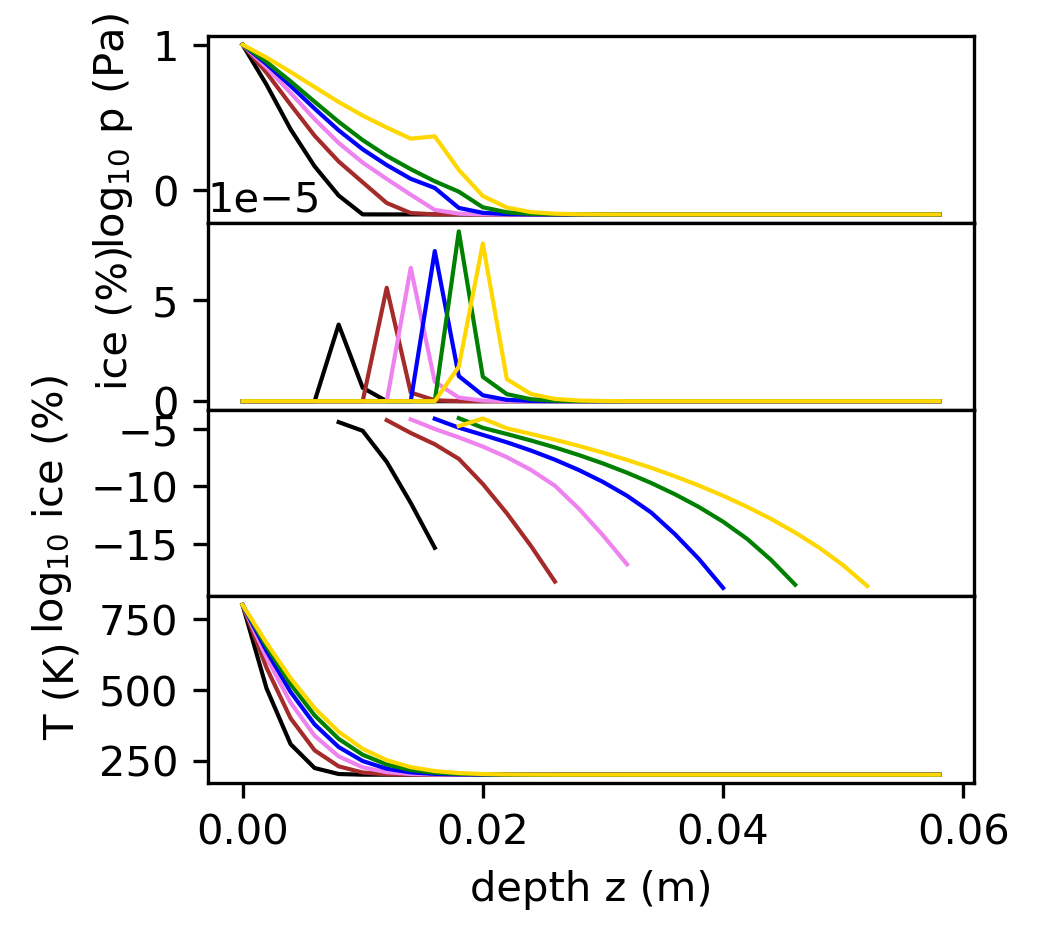

In [168]:
just_fig(iceD,'a',nshow_max=6)

### looks like amount of ice deposited depends on pore size and is inversely proportional to pore size?

In [169]:
if (iceD_redo == True):
    nshow_a=12; 
    iceD.set_top(200,100) # reset surface temperature to something lower 
    iceD.run_save_append(nshow_a) # run some more timesteps 

    with open(fileroot + 'iceD.pkl', 'wb') as file:
        pickle.dump(iceD, file)

else:
    with open(fileroot + 'iceD.pkl', 'rb') as file:
        iceD = pickle.load(file)

time = 288.0 s


ice_front_v01_iceDb.png


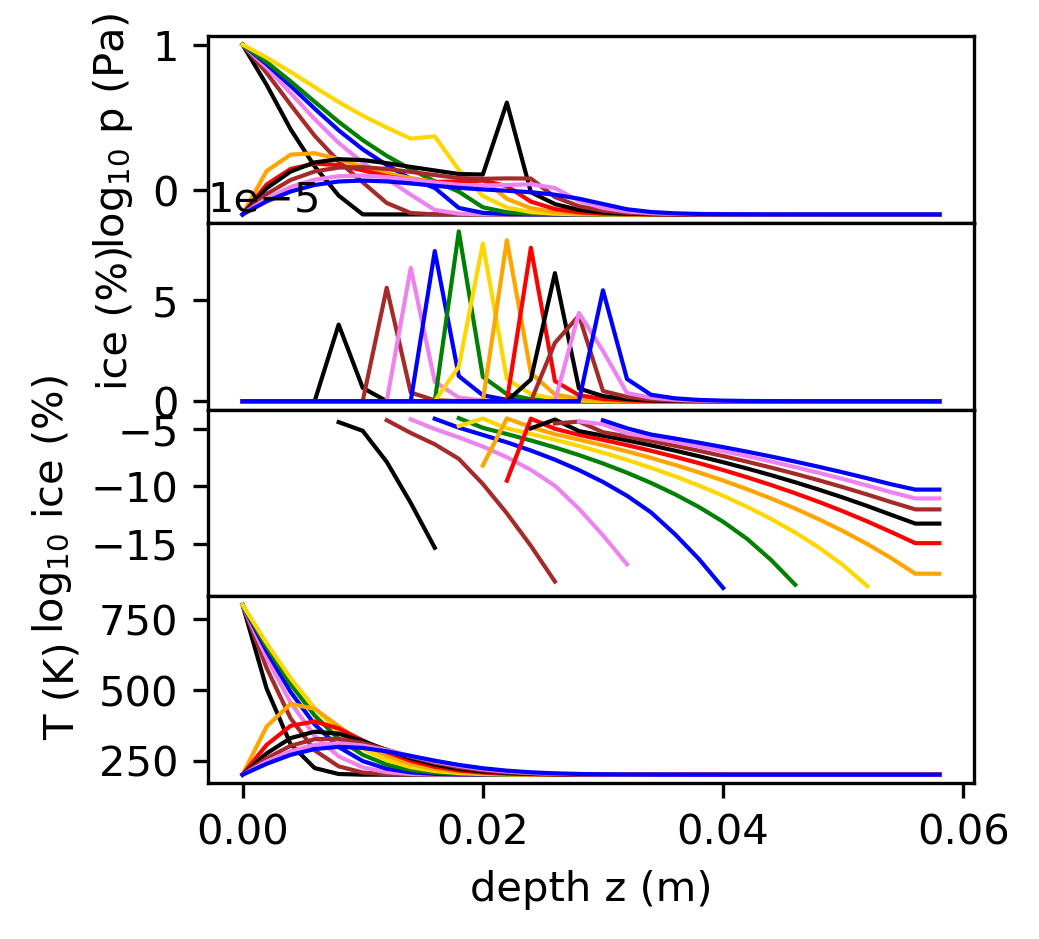

In [170]:
just_fig(iceD,'b')

In [ ]:
# if I put T0 = 30 or above I don't get any CO ice!  
# for dry objects, CO pressure can be below vapor pressure everywhere 
# the gas does not diffuse 
# the number density remains flat due to diffusion, but the temperature is 
# dropping which means that the vapor pressure remains low throughout the body 

In [205]:
# try a CO integration 
dz = 0.002 # 
nz = 30
porosity = 0.5
rpore = 1e-4   # 
T0 = 30
Ttop = 500 #K
Ptop = 1 #Pa
sim_label = 'CO_A'
kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
dt = dz**2/kappa/4   # timestep for heating of solid medium 
print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))
#fv_ice_init = [0.0,0.05,0.0,0.0]
onlist = [True, False, True, False,False]  # turn on CO, turn off ice 

n_s_fracs = np.array([0.9,0.0,0.1,0.0,0.0]) # volume number density fractions of nebular gas
CO_A = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,sim_label=sim_label,onlist = onlist)

nshow=6; nint=2
CO_A.run_save(nshow,nint)


dt = 6.00 s, rpore = 1.0e-04 m, dz = 2.0e-03 m 
time = 72.0 s


ice_front_v01_CO_Aa.png


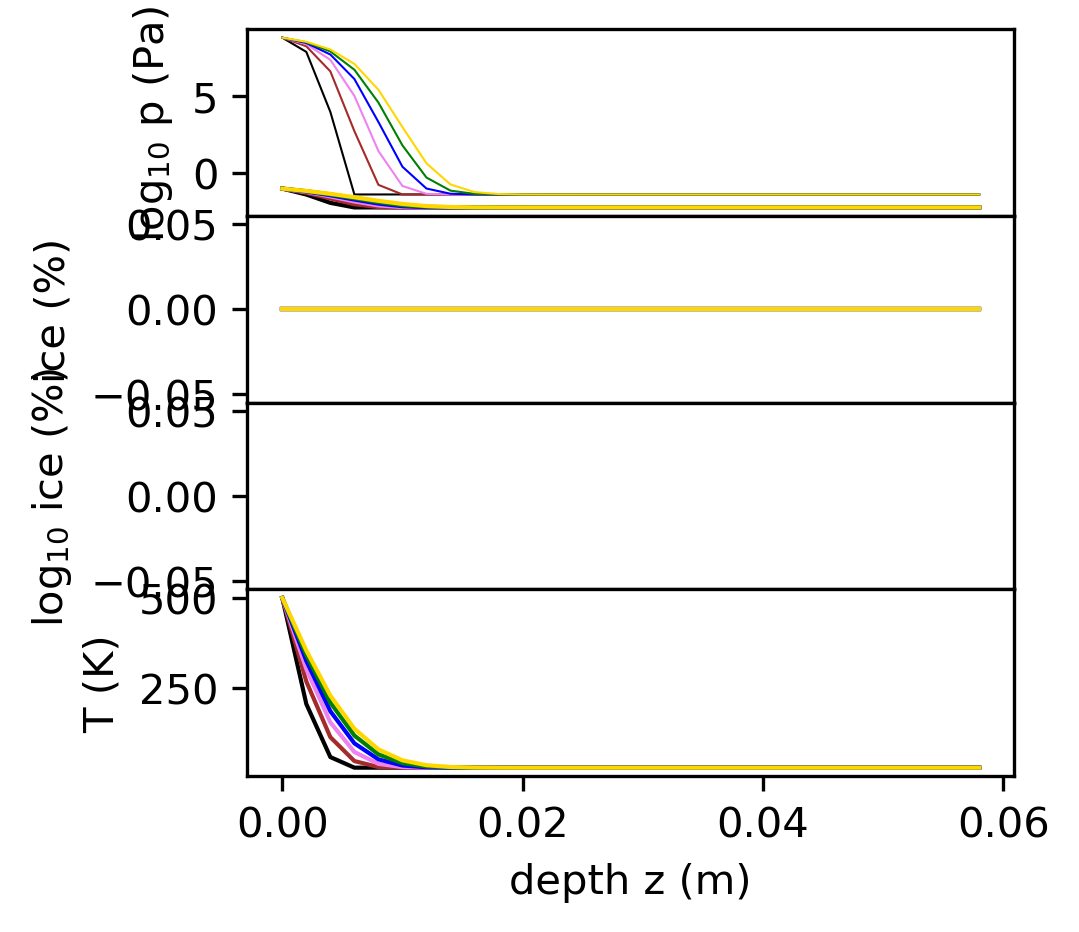

In [207]:
just_fig(CO_A,'a',k=2,plot_pv=True)  # show CO  # this explains why we don't have any ice
# partial pressure is always below the vapor pressure 

In [200]:
print(CO_A.onlist)
CO_A.load_Pv()
CO_A.Pvarr[2,:]

[True, False, True, False]


array([6.33391961e+08, 3.42347433e+08, 1.08484976e+08, 1.24393607e+07,
       2.64376573e+05, 9.93534579e+02, 4.36792714e+00, 1.86459932e-01,
       5.92352258e-02, 4.43344895e-02, 4.20283850e-02, 4.17358629e-02,
       4.17115708e-02, 4.17105994e-02, 4.17105994e-02, 4.17105994e-02,
       4.17105994e-02, 4.17105994e-02, 4.17105994e-02, 4.17105994e-02,
       4.17105994e-02, 4.17105994e-02, 4.17105994e-02, 4.17105994e-02,
       4.17105994e-02, 4.17105994e-02, 4.17105994e-02, 4.17105994e-02,
       4.17105994e-02, 4.17105994e-02])

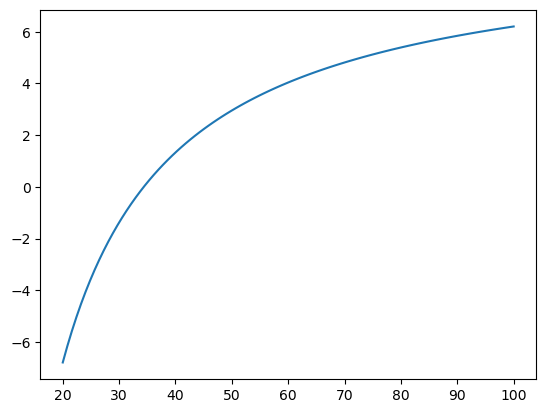

In [127]:
Tarr = np.linspace(20,100,100)
pv_2 = Pv(Tarr,2,cinfo)
plt.plot(Tarr,np.log10(pv_2))
plt.show()  # that seems no good, is way too high

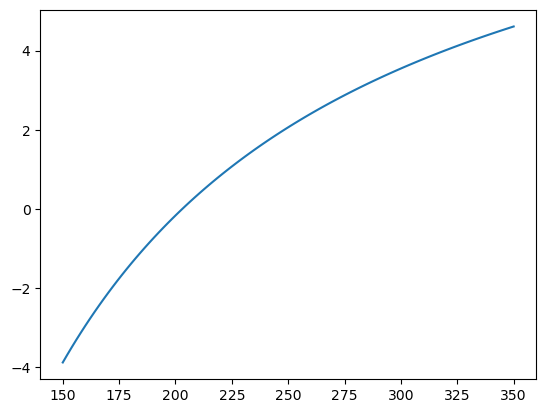

In [126]:
Tarr = np.linspace(150,350,100)
pv_2 = Pv(Tarr,1,cinfo)
plt.plot(Tarr,np.log10(pv_2))
plt.show()  # that seems no good, is way too high

In [16]:
# try a CO2 integration 
dz = 0.002 # 
nz = 30
porosity = 0.5
rpore = 1e-5   # 
T0 = 60
Ttop = 300 #K
Ptop = 1 #Pa
sim_label = 'CO2_A'
kappa = (1-porosity)*cinfo.K_Tuni/cinfo.C_uni
dt = dz**2/kappa/4   # timestep for heating of solid medium 
print('dt = {:.2f} s, rpore = {:.1e} m, dz = {:.1e} m '.format(dt,rpore,dz))
#fv_ice_init = [0.0,0.05,0.0,0.0]
onlist = [True, False, False, True,False]  # turn on CO2, turn off other ices

n_s_fracs = np.array([0.9,0.0,0.0,0.1,0.0]) # volume number density fractions of nebular gas
CO2_A = heat_sim(cinfo,dz,nz,porosity,rpore,T0,Ttop,Ptop,n_s_fracs,dt,sim_label=sim_label,onlist = onlist)

nshow=6; nint=5
CO2_A.run_save(nshow,nint)


dt = 6.00 s, rpore = 1.0e-05 m, dz = 2.0e-03 m 
time = 180.0 s


ice_front_v01_CO2_Aa.png


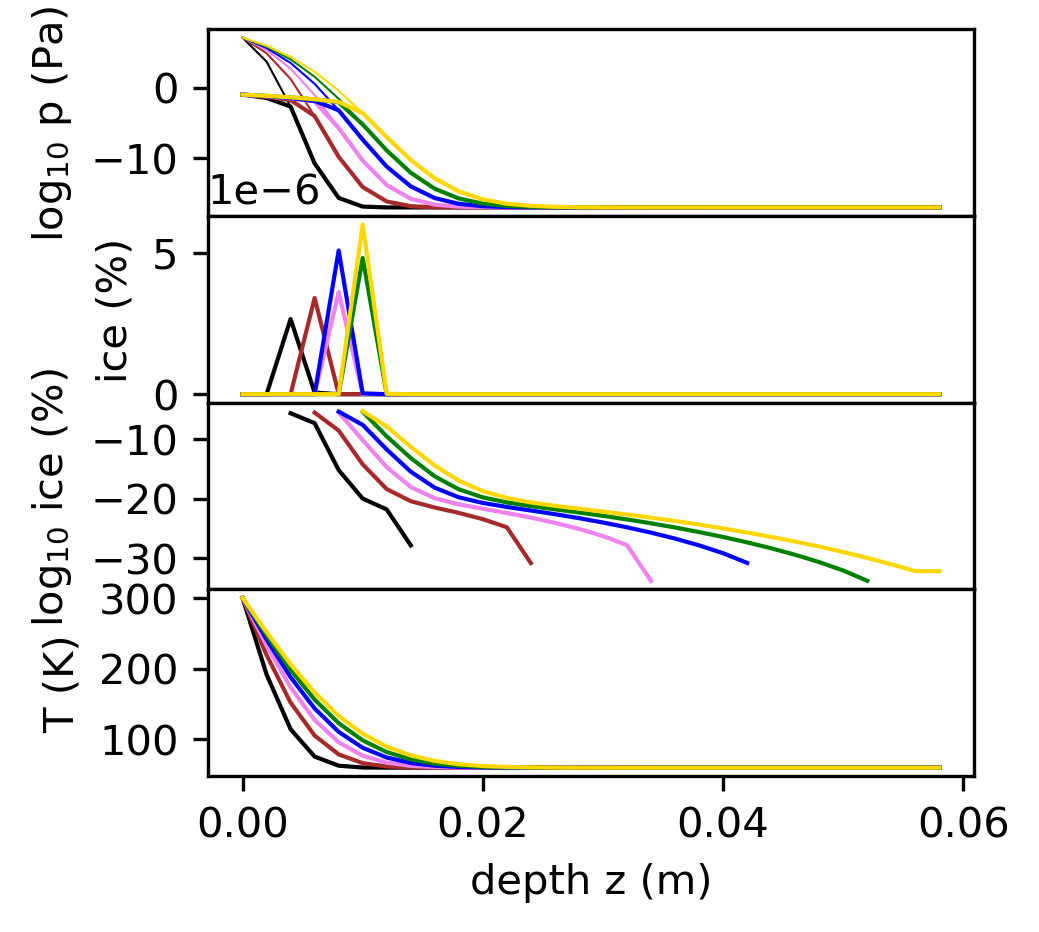

In [17]:
just_fig(CO2_A,'a',k=3,plot_pv=True)  # show CO2  